In [54]:
import importlib
import sys
import torch
import pickle
import os
import pandas as pd

sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')
sys.path.insert(0, '../../../..')

from aa_philipp.model_with_integrated_gradients.dropout_uncertainty_model import DropoutUncertaintyEncoderDecoderLSTM

In [55]:
#load model

file_path_model = '../../notebooks/training_variational_dropout/Helpdesk/Helpdesk_full_grad_norm_new_4layer.pkl'
model = DropoutUncertaintyEncoderDecoderLSTM.load(file_path_model, dropout=0.1)

# Load the dataset
file_path_data_set = '../../../encoded_data/test_weytjens//helpdesk_all_5_test.pkl'
helpdesk_test_dataset = torch.load(file_path_data_set, weights_only=False)

Data set categories:  ([('Activity', 16, {'Assign seriousness': 1, 'Closed': 2, 'Create SW anomaly': 3, 'DUPLICATE': 4, 'EOS': 5, 'INVALID': 6, 'Insert ticket': 7, 'RESOLVED': 8, 'Require upgrade': 9, 'Resolve SW anomaly': 10, 'Resolve ticket': 11, 'Schedule intervention': 12, 'Take in charge ticket': 13, 'VERIFIED': 14, 'Wait': 15}), ('Resource', 24, {'EOS': 1, 'Value 1': 2, 'Value 10': 3, 'Value 11': 4, 'Value 12': 5, 'Value 13': 6, 'Value 14': 7, 'Value 15': 8, 'Value 16': 9, 'Value 17': 10, 'Value 18': 11, 'Value 19': 12, 'Value 2': 13, 'Value 20': 14, 'Value 21': 15, 'Value 22': 16, 'Value 3': 17, 'Value 4': 18, 'Value 5': 19, 'Value 6': 20, 'Value 7': 21, 'Value 8': 22, 'Value 9': 23}), ('VariantIndex', 175, {'1.0': 1, '10.0': 2, '100.0': 3, '103.0': 4, '104.0': 5, '107.0': 6, '109.0': 7, '11.0': 8, '110.0': 9, '112.0': 10, '113.0': 11, '114.0': 12, '115.0': 13, '117.0': 14, '118.0': 15, '12.0': 16, '120.0': 17, '122.0': 18, '123.0': 19, '124.0': 20, '125.0': 21, '126.0': 22, '12

In [56]:
from typing import Optional, Tuple, List, Callable

@staticmethod
def forward_for_saliency(
        model,
        prefix: Optional[list] = None,
        last_event: Optional[list] = None,
        hx: Optional[Tuple] = None,
        z: Optional[Tuple[List, List]] = None,
        compute_saliency: bool = False,
        target_fn: Optional[Callable] = None,
        ):
            # Call encoder
            model.eval()
            """
            encoder section start
            """
            prefixes = model.encoder.data_enc_for_model(
            data=prefix
            )  # dim: Tensor: seq_len x batch_size x input feature (cat as embedding)

            prefixes.requires_grad_(compute_saliency)
            prefixes.retain_grad()
            # Outputs: All hidden states of all cells in the layer, h,c: last hidden state and cell state in the layer
            outputs, (h, c), _ = model.encoder.first_layer(input=prefixes, hx=None, z=None)

            # Pass through the remaining LSTM cell: Layer gets for: input: h_n Tensor, hx: (h, c)
            for _, layer in enumerate(model.encoder.hidden_layers):
                outputs, (h, c), _ = layer(input=outputs, hx=(h, c), z=None)

            h_enc, c_enc = h, c
            """
            encoder section end
            """
            # Get SOS event: Last prefix event:
            cat_prefixes, num_prefixes = prefix
            cat_sos_events = [cat_tens[:, -1:] for cat_tens in cat_prefixes]
            num_sos_events = [num_tens[:, -1:] for num_tens in num_prefixes]
            sos_event = [cat_sos_events, num_sos_events]
            """
            decoder section start
                preds, (h, c), z = self.decoder(
                    input=sos_event, hx=(h_enc, c_enc), z=None, pred=False
                )
            """
            prediction_means = [{}, {}]  # List of two dicts: [cat_pred_means, num_pred_means]
            prediction_vars = [{}, {}]   # List of two dicts: [cat_pred_vars, num_pred_vars]

            hx=(h_enc, c_enc)
            z=None
            # Process the input event through the encoder
            event = model.decoder.data_enc_for_model(data=sos_event, pred=False)  # dim: Tensor: seq_len x batch_size x input feature

            # first decoder call initialize sample mask
            if z is None:
                z_hidden_layers = []
                # Pass input_event through the first LSTM layer and all hidden layers
                outputs, (h, c), z_first_layer = model.decoder.first_layer(input=event, hx=hx, z=None)
                
                for i, lstm_cell in enumerate(model.decoder.hidden_layers):
                    outputs, (h, c), z_hidden_layer = lstm_cell(input=outputs, hx=(h, c), z=None)  
                    z_hidden_layers.append(z_hidden_layer)
                z = (z_first_layer, z_hidden_layers) 

            # Use same sample masks from previous iterations for decoder
            else:
                # Pass input_event through the first LSTM layer and all hidden layers
                outputs, (h, c), _ = model.decoder.first_layer(input=event, hx=hx, z=z[0])
                
                for i, lstm_cell in enumerate(model.decoder.hidden_layers):
                    outputs, (h, c), _ = lstm_cell(input=outputs, hx=(h, c), z=z[1][i])
                
            # Get the last output (outputs[-1]) for predictions
            final_output = outputs[-1]

            # Unpack output_sizes into categorical and numerical dicts
            cat_output_sizes, num_output_sizes = model.decoder.output_sizes

            # Predict means and variances for categorical features
            for key in cat_output_sizes:
                pred_mean = model.decoder.output_layers[f"{key}_mean"](final_output)
                prediction_means[0][f"{key}_mean"] = pred_mean  # Store in the first dict (for cat features)
                
                pred_var = model.decoder.output_layers[f"{key}_var"](final_output)
                prediction_vars[0][f"{key}_var"] = pred_var  # Store in the first dict (for cat features)

            # Predict means and variances for numerical features
            for key in num_output_sizes:
                pred_mean = model.decoder.output_layers[f"{key}_mean"](final_output)
                prediction_means[1][f"{key}_mean"] = pred_mean
                
                pred_var = model.decoder.output_layers[f"{key}_var"](final_output)
                prediction_vars[1][f"{key}_var"] = pred_var

                # Get raw log-variance prediction
                # raw_logvar = model.output_layers[f"{key}_var"](final_output)
                # LOGVAR_BOUND: 3.0 -> var = [exp(-3.0)=0.05, exp(3.0)=20]
                # LOGVAR_BOUND = 6.0
                # Bound the log-variance using tanh activation
                # bounded_logvar = LOGVAR_BOUND * torch.tanh(raw_logvar / LOGVAR_BOUND)
                # prediction_vars[1][f"{key}_var"] = bounded_logvar  # Store the safe version
                
            predictions = [prediction_means, prediction_vars]

            """
            decoder section end
            """
            if compute_saliency:
                if target_fn is None:
                    raise ValueError("target_fn must be provided when compute_saliency=True")

                target = target_fn(predictions)
                target.backward()

                saliency_grad = prefixes.grad.detach()
                model.zero_grad()

                return predictions, (h, c), z, saliency_grad

            return predictions, (h, c), z
            
        
        

In [57]:

import evaluation.evaluation
importlib.reload(evaluation.evaluation)
from evaluation.evaluation import Evaluation


new_eval = Evaluation(model=model, 
                                   dataset=helpdesk_test_dataset,
                                   concept_name='Activity',
                                   #growing_num_values = [],
                                   growing_num_values = ['case_elapsed_time'],
                                   all_cat=['Activity', 'Resource'],
                                   all_num=['case_elapsed_time', 'event_elapsed_time'])


cases = new_eval._get_cases_from_dataset()

case_items = list(new_eval.cases.items())


"""
for i, (case_name, full_case) in enumerate(case_items):
    for j, (prefix_len, prefix, suffix) in enumerate(new_eval._iterate_case(full_case)):
        
        # prefix: ([cat_tensors], [num_tensors])
        cat_list, num_list = prefix

        # Stack inputs
        cat_tensor = torch.stack(cat_list, dim=1)  # [1, C, T]
        num_tensor = torch.stack(num_list, dim=1)  # [1, N, T]

        prefix_tensor = (cat_tensor, num_tensor)

        predictions, (h, c), z, saliency_grad = forward_for_saliency(new_eval.model,(cat_list, num_list), compute_saliency=True, target_fn=target_fn)
        saliency_grad = saliency_grad.squeeze(1)
        

"""

'\nfor i, (case_name, full_case) in enumerate(case_items):\n    for j, (prefix_len, prefix, suffix) in enumerate(new_eval._iterate_case(full_case)):\n\n        # prefix: ([cat_tensors], [num_tensors])\n        cat_list, num_list = prefix\n\n        # Stack inputs\n        cat_tensor = torch.stack(cat_list, dim=1)  # [1, C, T]\n        num_tensor = torch.stack(num_list, dim=1)  # [1, N, T]\n\n        prefix_tensor = (cat_tensor, num_tensor)\n\n        predictions, (h, c), z, saliency_grad = forward_for_saliency(new_eval.model,(cat_list, num_list), compute_saliency=True, target_fn=target_fn)\n        saliency_grad = saliency_grad.squeeze(1)\n\n\n'

# IG

In [58]:
from captum.attr import IntegratedGradients

def forward_for_ig(
    model,
    prefixes_embedded: torch.Tensor,
    prefix_raw,
    target_fn: Callable,
):

    model.eval()

    # ---------- Encoder ----------
    outputs, (h, c), _ = model.encoder.first_layer(
        input=prefixes_embedded, hx=None, z=None
    )

    for layer in model.encoder.hidden_layers:
        outputs, (h, c), _ = layer(input=outputs, hx=(h, c), z=None)

    h_enc, c_enc = h, c

    # ---------- SOS event ----------
    cat_prefixes, num_prefixes = prefix_raw
    cat_sos_events = [cat[:, -1:] for cat in cat_prefixes]
    num_sos_events = [num[:, -1:] for num in num_prefixes]
    sos_event = [cat_sos_events, num_sos_events]

    # ---------- Decoder ----------
    prediction_means = [{}, {}]
    prediction_vars = [{}, {}]

    hx = (h_enc, c_enc)
    z = None

    event = model.decoder.data_enc_for_model(data=sos_event, pred=False)

    outputs, (h, c), z_first = model.decoder.first_layer(
        input=event, hx=hx, z=None
    )

    z_hidden = []
    for lstm_cell in model.decoder.hidden_layers:
        outputs, (h, c), z_h = lstm_cell(
            input=outputs, hx=(h, c), z=None
        )
        z_hidden.append(z_h)

    z = (z_first, z_hidden)

    final_output = outputs[-1]

    cat_output_sizes, num_output_sizes = model.decoder.output_sizes

    for key in cat_output_sizes:
        prediction_means[0][f"{key}_mean"] = model.decoder.output_layers[f"{key}_mean"](final_output)
        prediction_vars[0][f"{key}_var"]  = model.decoder.output_layers[f"{key}_var"](final_output)

    for key in num_output_sizes:
        prediction_means[1][f"{key}_mean"] = model.decoder.output_layers[f"{key}_mean"](final_output)
        prediction_vars[1][f"{key}_var"]  = model.decoder.output_layers[f"{key}_var"](final_output)

    predictions = [prediction_means, prediction_vars]

    # ---------- Target ----------
    target = target_fn(predictions)

    return target

In [59]:
def compute_integrated_gradients(
    model,
    prefix,
    target_fn: Callable,
    baselines: Optional[torch.Tensor] = None,
    n_steps: int = 50,
):
    """
    Returns:
        attributions: Tensor same shape as encoder input
    """

    # Encode prefix as model input
    prefixes_embedded = model.encoder.data_enc_for_model(data=prefix)
    prefixes_embedded = prefixes_embedded.detach()
    prefixes_embedded.requires_grad_(True)

    if baselines is None:
        baselines = torch.zeros_like(prefixes_embedded)

    ig = IntegratedGradients(
        lambda x: forward_for_ig(
            model=model,
            prefixes_embedded=x,
            prefix_raw=prefix,
            target_fn=target_fn,
        )
    )

    attributions = ig.attribute(
        inputs=prefixes_embedded,
        baselines=baselines,
        n_steps=n_steps,
    )

    ig_sum = attributions.sum()
    delta = forward_for_ig(model=model,
            prefixes_embedded=prefixes_embedded,
            prefix_raw=prefix,
            target_fn=target_fn,) - forward_for_ig(model=model,
            prefixes_embedded=baselines,
            prefix_raw=prefix,
            target_fn=target_fn,)

    print(ig_sum.item(), delta.item())

    return attributions


In [60]:
def target_fn_case_elapsed_time_mean(preds):
    return preds[0][1]["case_elapsed_time_mean"][0][0].unsqueeze(0)

In [61]:
def target_fn_activity(preds, index):
    return preds[0][0]["Activity_mean"][0][index].unsqueeze(0)

In [68]:
from tqdm import tqdm

results_rows = []
for i, (case_name, full_case) in enumerate(tqdm(case_items)):
    for j, (prefix_len, prefix, suffix) in enumerate(new_eval._iterate_case(full_case)):

        attributions_case_elapsed_time = compute_integrated_gradients(
            model=model,
            prefix=prefix,
            target_fn=target_fn_case_elapsed_time_mean,
            baselines=None,     # defaults to zero embedding
            n_steps=20
        )


        attributions_resolve_ticket = compute_integrated_gradients(
            model=model,
            prefix=prefix,
            target_fn=lambda x: target_fn_activity(x,10), # index 10 is "resolve ticket"
            baselines=None,     # defaults to zero embedding
            n_steps=20
        )

        attributions_close = compute_integrated_gradients(
            model=model,
            prefix=prefix,
            target_fn=lambda x: target_fn_activity(x,1), # index 10 is "Closed"
            baselines=None,     # defaults to zero embedding
            n_steps=20
        )

        row = {
            'case_name': case_name,
            'prefix_len':prefix_len,
            'attributions_case_elapsed_time': attributions_case_elapsed_time,
            "attributions_resolve_ticket":attributions_resolve_ticket,
            "attributions_close":attributions_close
        }

        results_rows.append(row)

results_df = pd.DataFrame(results_rows)

        
        # output_attributes x seq_steps (padded) x batch_size x input_attributes
        #  for step in range(prefix_len):
        # list with columns time_output_value, ..all categorical values, prefix length, prefix, suffix, prediction

  0%|          | 0/916 [00:00<?, ?it/s]

4.3429732613731176e-05 -1.2177530527114868
2.0624602257157676e-05 0.5359728336334229
-2.823847535182722e-05 2.0342371463775635
-1.815153518691659e-05 -0.33112260699272156
2.4517385099898092e-05 0.6061117649078369
-1.6566900740144774e-05 1.1258435249328613
-6.450489308917895e-06 0.761088490486145
1.2072603567503393e-05 0.15900564193725586


  0%|          | 1/916 [00:08<2:09:34,  8.50s/it]

-0.0006290408782660961 -0.0012267827987670898
1.1077177077822853e-05 -0.6919512152671814
3.7759498809464276e-05 0.3882908821105957
-2.0394714738358743e-05 1.7532155513763428
8.766261998971459e-06 -0.42660239338874817
2.3945274733705446e-05 0.6966161727905273
-1.180896651931107e-05 0.7988500595092773
1.8908869606093504e-05 0.7774389982223511
-5.410780431702733e-05 0.30389928817749023


  0%|          | 2/916 [00:17<2:15:21,  8.89s/it]

-3.0058814445510507e-05 0.050859928131103516


  0%|          | 2/916 [00:18<2:21:00,  9.26s/it]


KeyboardInterrupt: 

In [69]:
import pickle

with open ("results_store_integrated_gradients_helpdesk_on_case_elapsed_time_and_ticket_resolved_and_closed.pkl", "wb") as f:
   pickle.dump(results_df,f)

In [73]:
import pickle
import pandas as pd

with open ("results_store_integrated_gradients_helpdesk_on_case_elapsed_time_and_ticket_resolved_and_closed.pkl", "rb") as f:
    results_df = pickle.load(f)

results_df = pd.DataFrame(results_df)

In [74]:
results_df.head()

,case_name,prefix_len,attributions_case_elapsed_time,attributions_resolve_ticket,attributions_close
0,Case 1016,1,"[[[tensor(4.7566e-09, grad_fn=<UnbindBackward0...","[[[tensor(7.0320e-07, grad_fn=<UnbindBackward0...","[[[tensor(-1.0431e-07, grad_fn=<UnbindBackward..."
1,Case 1016,2,"[[[tensor(-8.0076e-08, grad_fn=<UnbindBackward...","[[[tensor(-1.2051e-09, grad_fn=<UnbindBackward...","[[[tensor(-8.4562e-09, grad_fn=<UnbindBackward..."
2,Case 1016,3,"[[[tensor(-4.5823e-07, grad_fn=<UnbindBackward...","[[[tensor(-1.1872e-07, grad_fn=<UnbindBackward...","[[[tensor(-6.2172e-09, grad_fn=<UnbindBackward..."
3,Case 102,1,"[[[tensor(-1.8375e-08, grad_fn=<UnbindBackward...","[[[tensor(-1.1296e-09, grad_fn=<UnbindBackward...","[[[tensor(-4.0667e-09, grad_fn=<UnbindBackward..."
4,Case 102,2,"[[[tensor(6.7621e-09, grad_fn=<UnbindBackward0...","[[[tensor(2.1809e-08, grad_fn=<UnbindBackward0...","[[[tensor(1.6472e-08, grad_fn=<UnbindBackward0..."


In [76]:
results_df.loc[0,"attributions_resolve_ticket"].max()



tensor(3.5683e-06, grad_fn=<MaxBackward1>)

In [77]:
import pickle

with open("results_store_helpdesk_results.pkl", "rb") as f:
    inference_results = pickle.load(f)

inference_results = pd.DataFrame(inference_results)

In [78]:
results_df["attributions_resolve_ticket"].shape

(9,)

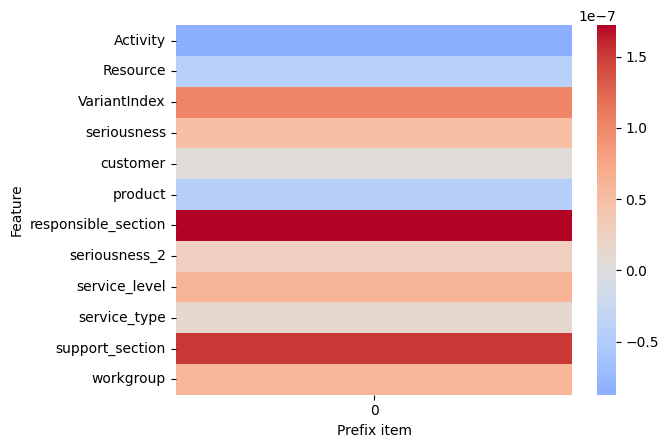

Timestep 1  \
Prefix          Activity              Assign seriousness   
                Resource                         Value 8   
                VariantIndex                         1.0   
                seriousness                      Value 1   
                customer                         Value 8   
                product                          Value 3   
                responsible_section              Value 1   
                seriousness_2                    Value 2   
                service_level                    Value 2   
                service_type                     Value 2   
                support_section                  Value 1   
                workgroup                        Value 2   
                case_elapsed_time               0.070602   
                event_elapsed_time           963303.3125   
                day_in_week                          2.0   
                seconds_in_day              27781.000314   
Mean Prediction Activity                  Resolve ticket   
                Resource                         Value 2   
                case_elapsed_time     [699906.249423597]   
                event_elapsed_time   [366208.9382920583]   

                                               Timestep 2  \
Prefix          Activity                              NaN   
                Resource                              NaN   
                VariantIndex                          NaN   
                seriousness                           NaN   
                customer                              NaN   
                product                               NaN   
                responsible_section                   NaN   
                seriousness_2                         NaN   
                service_level                         NaN   
                service_type                          NaN   
                support_section                       NaN   
                workgroup                             NaN   
                case_elapsed_time                     NaN   
                event_elapsed_time                    NaN   
                day_in_week                           NaN   
                seconds_in_day                        NaN   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time    [2224358.5507657807]   
                event_elapsed_time   [1150600.1999439963]   

                                               Timestep 3  
Prefix          Activity                              NaN  
                Resource                              NaN  
                VariantIndex                          NaN  
                seriousness                           NaN  
                customer                              NaN  
                product                               NaN  
                responsible_section                   NaN  
                seriousness_2                         NaN  
                service_level                         NaN  
                service_type                          NaN  
                support_section                       NaN  
                workgroup                             NaN  
                case_elapsed_time                     NaN  
                event_elapsed_time                    NaN  
                day_in_week                           NaN  
                seconds_in_day                        NaN  
Mean Prediction Activity                           Closed  
                Resource                          Value 5  
                case_elapsed_time    [2224358.5507657807]  
                event_elapsed_time   [1079315.3239295376]

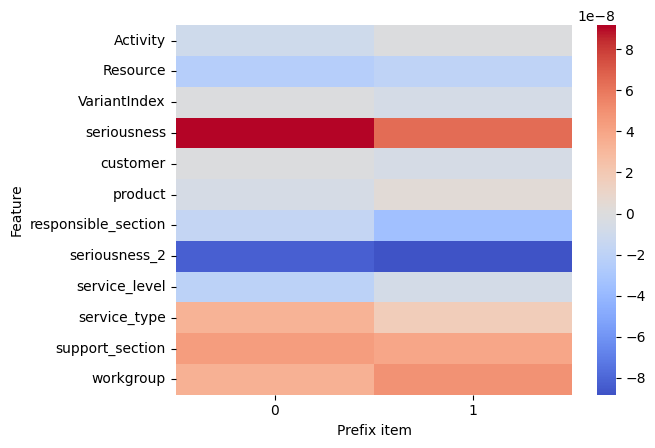

Timestep 1  \
Prefix          Activity              Assign seriousness   
                Resource                         Value 8   
                VariantIndex                         1.0   
                seriousness                      Value 1   
                customer                         Value 8   
                product                          Value 3   
                responsible_section              Value 1   
                seriousness_2                    Value 2   
                service_level                    Value 2   
                service_type                     Value 2   
                support_section                  Value 1   
                workgroup                        Value 2   
                case_elapsed_time               0.070602   
                event_elapsed_time           963303.3125   
                day_in_week                          2.0   
                seconds_in_day              27781.000314   
Mean Prediction Activity                  Resolve ticket   
                Resource                         Value 2   
                case_elapsed_time    [1468898.994064969]   
                event_elapsed_time   [625537.7645886724]   

                                                Timestep 2  
Prefix          Activity             Take in charge ticket  
                Resource                           Value 8  
                VariantIndex                           1.0  
                seriousness                        Value 1  
                customer                           Value 8  
                product                            Value 3  
                responsible_section                Value 1  
                seriousness_2                      Value 2  
                service_level                      Value 2  
                service_type                       Value 2  
                support_section                    Value 1  
                workgroup                          Value 2  
                case_elapsed_time               149.029932  
                event_elapsed_time              148.938768  
                day_in_week                            2.0  
                seconds_in_day                 27930.00031  
Mean Prediction Activity                            Closed  
                Resource                           Value 5  
                case_elapsed_time       [3213337.27693169]  
                event_elapsed_time       [1855780.7243394]

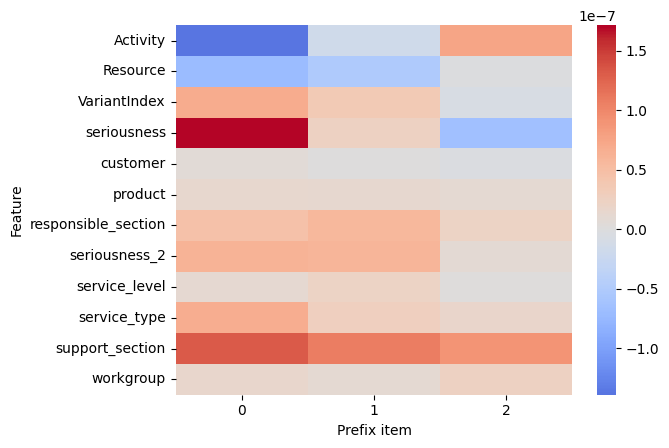

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 8   
                VariantIndex                          1.0   
                seriousness                       Value 1   
                customer                          Value 8   
                product                           Value 3   
                responsible_section               Value 1   
                seriousness_2                     Value 2   
                service_level                     Value 2   
                service_type                      Value 2   
                support_section                   Value 1   
                workgroup                         Value 2   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           2.0   
                seconds_in_day               27781.000314   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time    [3435032.1257776767]   
                event_elapsed_time   [2032070.6655079303]   

                                                Timestep 2      Timestep 3  
Prefix          Activity             Take in charge ticket  Resolve ticket  
                Resource                           Value 8        Value 16  
                VariantIndex                           1.0             1.0  
                seriousness                        Value 1         Value 1  
                customer                           Value 8         Value 8  
                product                            Value 3         Value 3  
                responsible_section                Value 1         Value 1  
                seriousness_2                      Value 2         Value 2  
                service_level                      Value 2         Value 2  
                service_type                       Value 2         Value 2  
                support_section                    Value 1         Value 1  
                workgroup                          Value 2         Value 2  
                case_elapsed_time               149.029932    26071.995951  
                event_elapsed_time              148.938768     25922.95599  
                day_in_week                            2.0             2.0  
                seconds_in_day                 27930.00031    53853.000029  
Mean Prediction Activity                               NaN             NaN  
                Resource                               NaN             NaN  
                case_elapsed_time                      NaN             NaN  
                event_elapsed_time                     NaN             NaN

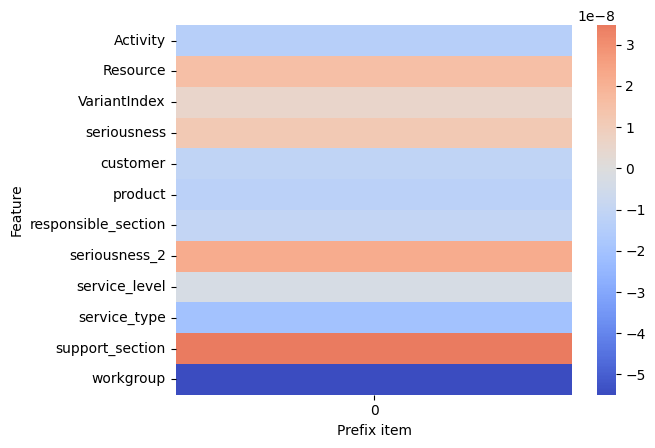

Timestep 1            Timestep 2
Prefix          Activity              Assign seriousness                   NaN
                Resource                         Value 4                   NaN
                VariantIndex                         1.0                   NaN
                seriousness                      Value 1                   NaN
                customer                        Value 62                   NaN
                product                          Value 3                   NaN
                responsible_section              Value 1                   NaN
                seriousness_2                    Value 4                   NaN
                service_level                    Value 1                   NaN
                service_type                     Value 1                   NaN
                support_section                  Value 1                   NaN
                workgroup                        Value 1                   NaN
                case_elapsed_time               0.070602                   NaN
                event_elapsed_time           963303.3125                   NaN
                day_in_week                         -0.0                   NaN
                seconds_in_day              32968.999659                   NaN
Mean Prediction Activity                  Resolve ticket                Closed
                Resource                         Value 2               Value 5
                case_elapsed_time    [777030.0347539268]   [2474231.335498253]
                event_elapsed_time   [367728.4623835896]  [1301448.4981970133]

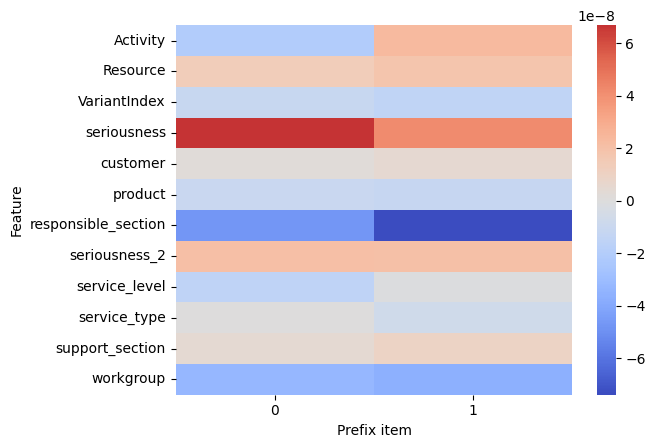

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 4   
                VariantIndex                          1.0   
                seriousness                       Value 1   
                customer                         Value 62   
                product                           Value 3   
                responsible_section               Value 1   
                seriousness_2                     Value 4   
                service_level                     Value 1   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                          -0.0   
                seconds_in_day               32968.999659   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time    [1584298.9267819193]   
                event_elapsed_time     [672506.501578377]   

                                                Timestep 2  
Prefix          Activity             Take in charge ticket  
                Resource                           Value 4  
                VariantIndex                           1.0  
                seriousness                        Value 1  
                customer                          Value 62  
                product                            Value 3  
                responsible_section                Value 1  
                seriousness_2                      Value 4  
                service_level                      Value 1  
                service_type                       Value 1  
                support_section                    Value 1  
                workgroup                          Value 1  
                case_elapsed_time                28.000476  
                event_elapsed_time               27.995833  
                day_in_week                           -0.0  
                seconds_in_day                 32996.99974  
Mean Prediction Activity                            Closed  
                Resource                           Value 5  
                case_elapsed_time     [3266100.4848477812]  
                event_elapsed_time    [1855818.1217740776]

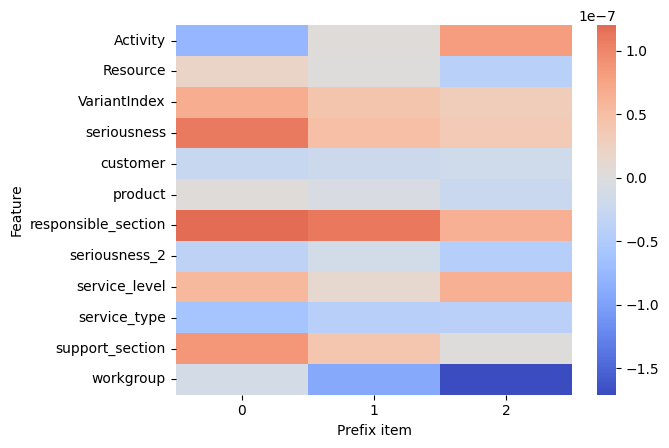

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 4   
                VariantIndex                          1.0   
                seriousness                       Value 1   
                customer                         Value 62   
                product                           Value 3   
                responsible_section               Value 1   
                seriousness_2                     Value 4   
                service_level                     Value 1   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                          -0.0   
                seconds_in_day               32968.999659   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time    [3446540.4590666313]   
                event_elapsed_time   [2040415.8201555554]   

                                                Timestep 2      Timestep 3  
Prefix          Activity             Take in charge ticket  Resolve ticket  
                Resource                           Value 4         Value 2  
                VariantIndex                           1.0             1.0  
                seriousness                        Value 1         Value 1  
                customer                          Value 62        Value 62  
                product                            Value 3         Value 3  
                responsible_section                Value 1         Value 1  
                seriousness_2                      Value 4         Value 4  
                service_level                      Value 1         Value 1  
                service_type                       Value 1         Value 1  
                support_section                    Value 1         Value 1  
                workgroup                          Value 1         Value 1  
                case_elapsed_time                28.000476    82957.065346  
                event_elapsed_time               27.995833    82928.989434  
                day_in_week                           -0.0             1.0  
                seconds_in_day                 32996.99974    29525.999706  
Mean Prediction Activity                               NaN             NaN  
                Resource                               NaN             NaN  
                case_elapsed_time                      NaN             NaN  
                event_elapsed_time                     NaN             NaN

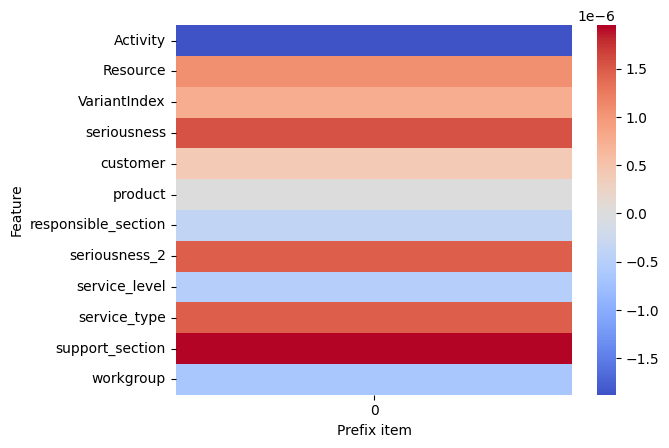

Timestep 1  \
Prefix          Activity                Assign seriousness   
                Resource                           Value 1   
                VariantIndex                           2.0   
                seriousness                        Value 1   
                customer                          Value 71   
                product                            Value 1   
                responsible_section                Value 1   
                seriousness_2                      Value 1   
                service_level                      Value 3   
                service_type                       Value 1   
                support_section                    Value 1   
                workgroup                          Value 1   
                case_elapsed_time                 0.070602   
                event_elapsed_time             963303.3125   
                day_in_week                            2.0   
                seconds_in_day                54445.000002   
Mean Prediction Activity             Take in charge ticket   
                Resource                           Value 2   
                case_elapsed_time     [338326.76787914836]   
                event_elapsed_time    [283788.03195523843]   

                                                Timestep 2  \
Prefix          Activity                               NaN   
                Resource                               NaN   
                VariantIndex                           NaN   
                seriousness                            NaN   
                customer                               NaN   
                product                                NaN   
                responsible_section                    NaN   
                seriousness_2                          NaN   
                service_level                          NaN   
                service_type                           NaN   
                support_section                        NaN   
                workgroup                              NaN   
                case_elapsed_time                      NaN   
                event_elapsed_time                     NaN   
                day_in_week                            NaN   
                seconds_in_day                         NaN   
Mean Prediction Activity             Take in charge ticket   
                Resource                           Value 2   
                case_elapsed_time     [494094.25046030176]   
                event_elapsed_time    [216201.37996599195]   

                                              Timestep 3            Timestep 4  
Prefix          Activity                             NaN                   NaN  
                Resource                             NaN                   NaN  
                VariantIndex                         NaN                   NaN  
                seriousness                          NaN                   NaN  
                customer                             NaN                   NaN  
                product                              NaN                   NaN  
                responsible_section                  NaN                   NaN  
                seriousness_2                        NaN                   NaN  
                service_level                        NaN                   NaN  
                service_type                         NaN                   NaN  
                support_section                      NaN                   NaN  
                workgroup                            NaN                   NaN  
                case_elapsed_time                    NaN                   NaN  
                event_elapsed_time                   NaN                   NaN  
                day_in_week                          NaN                   NaN  
                seconds_in_day                       NaN                   NaN  
Mean Prediction Activity                  Resolve ticket         

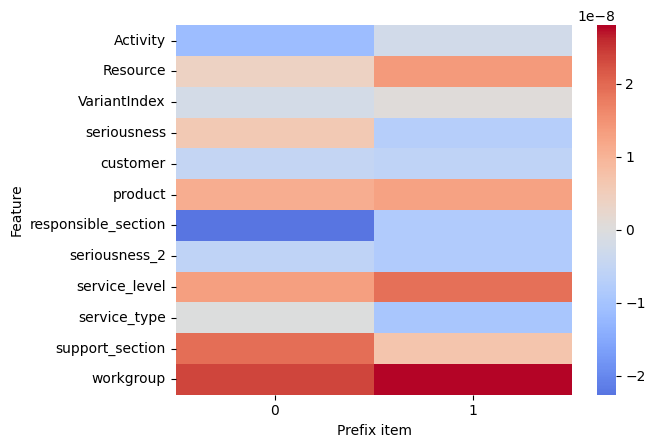

Timestep 1  \
Prefix          Activity              Assign seriousness   
                Resource                         Value 1   
                VariantIndex                         2.0   
                seriousness                      Value 1   
                customer                        Value 71   
                product                          Value 1   
                responsible_section              Value 1   
                seriousness_2                    Value 1   
                service_level                    Value 3   
                service_type                     Value 1   
                support_section                  Value 1   
                workgroup                        Value 1   
                case_elapsed_time               0.070602   
                event_elapsed_time           963303.3125   
                day_in_week                          2.0   
                seconds_in_day              54445.000002   
Mean Prediction Activity                  Resolve ticket   
                Resource                         Value 2   
                case_elapsed_time     [777766.011446921]   
                event_elapsed_time   [332703.0475065778]   

                                                Timestep 2  
Prefix          Activity             Take in charge ticket  
                Resource                           Value 1  
                VariantIndex                           2.0  
                seriousness                        Value 1  
                customer                          Value 71  
                product                            Value 1  
                responsible_section                Value 1  
                seriousness_2                      Value 1  
                service_level                      Value 3  
                service_type                       Value 1  
                support_section                    Value 1  
                workgroup                          Value 1  
                case_elapsed_time                 9.013061  
                event_elapsed_time                 9.02078  
                day_in_week                            2.0  
                seconds_in_day                54453.999593  
Mean Prediction Activity                            Closed  
                Resource                           Value 5  
                case_elapsed_time     [2410379.4774074215]  
                event_elapsed_time    [1276023.8153865738]

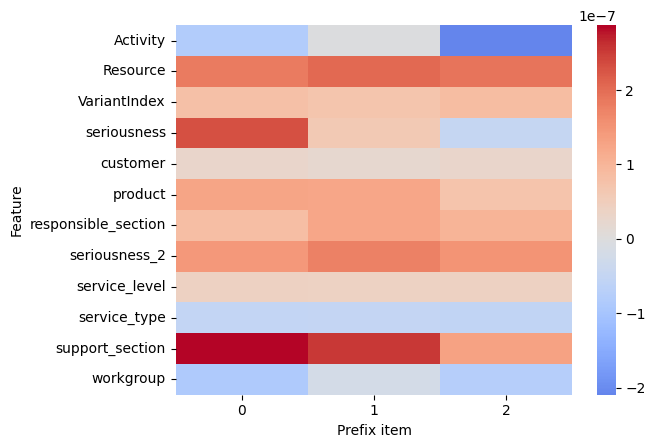

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                VariantIndex                          2.0   
                seriousness                       Value 1   
                customer                         Value 71   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 3   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           2.0   
                seconds_in_day               54445.000002   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time    [1818347.4776183176]   
                event_elapsed_time    [864995.4386384833]   

                                                Timestep 2     Timestep 3  
Prefix          Activity             Take in charge ticket           Wait  
                Resource                           Value 1        Value 1  
                VariantIndex                           2.0            2.0  
                seriousness                        Value 1        Value 1  
                customer                          Value 71       Value 71  
                product                            Value 1        Value 1  
                responsible_section                Value 1        Value 1  
                seriousness_2                      Value 1        Value 1  
                service_level                      Value 3        Value 3  
                service_type                       Value 1        Value 1  
                support_section                    Value 1        Value 1  
                workgroup                          Value 1        Value 1  
                case_elapsed_time                 9.013061  508925.993816  
                event_elapsed_time                 9.02078  508916.996351  
                day_in_week                            2.0            1.0  
                seconds_in_day                54453.999593   44971.000006  
Mean Prediction Activity                            Closed            NaN  
                Resource                           Value 5            NaN  
                case_elapsed_time      [3252994.758736482]            NaN  
                event_elapsed_time     [1837712.605123189]            NaN

In [79]:
from classes.event import Event, HelpdeskEvent
from classes.sequence import Sequence
from classes.suffix_samples import SuffixSamples
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



def fetch_attributions(row):
    prefix_length = row.loc["prefix_len"]
    case_name = row.loc["case_name"]
    attribution_tensor = row.loc["attributions_close"].squeeze(0)
    attribution_list = []
    for time_step in attribution_tensor[-prefix_length:]:

        attr = unpack_attribution(time_step[0])
        attribution_list.append(attr)
    

    return attribution_list, prefix_length, case_name


def unpack_attribution(sample_tensor):
    start_index = 0
    attribution_dict = {}

    for idx, encoded_attribute in enumerate(new_eval.prefix_cat_attributes):
        embedding_dim = new_eval.model.encoder.embeddings[idx].embedding_dim
        attribution_dict[encoded_attribute] = sample_tensor[start_index:start_index+embedding_dim].mean()
        start_index += embedding_dim

    return attribution_dict


def visualize_attribution(attribution_list, prefix_len, case_name, inference_results):
    # --- Attribution heatmap ---
    df_attr = pd.DataFrame(
        [{k: v.detach().item() for k, v in d.items()} for d in attribution_list]
    )
    sns.heatmap(df_attr.T, center=0, cmap="coolwarm")
    plt.xlabel("Prefix item")
    plt.ylabel("Feature")
    plt.show()

    # --- Fetch corresponding inference row ---
    row = inference_results[
        (inference_results["prefix_len"] == prefix_len) &
        (inference_results["case_name"] == case_name)
    ]

    if row.empty:
        print("No prefix or mean prediction found for this row.")
        return

    prefix = row.iloc[0]["prefix"]
    mean_prediction = row.iloc[0]["mean_prediction"]

    # --- Prefix: list of dicts (one dict per timestep) ---
    df_prefix = pd.DataFrame(prefix).T
    df_prefix.columns = [f"Timestep {i+1}" for i in range(df_prefix.shape[1])]

    # --- Mean prediction: list of dicts (one dict per timestep) ---
    # unwrap scalar lists if needed
    cleaned_mean_pred = []
    for step in mean_prediction:
        cleaned_step = {
            k: (v[0] if isinstance(v, list) and len(v) == 1 else v)
            for k, v in step.items()
        }
        cleaned_mean_pred.append(cleaned_step)

    df_mean_pred = pd.DataFrame(cleaned_mean_pred).T
    df_mean_pred.columns = [f"Timestep {i+1}" for i in range(df_mean_pred.shape[1])]

    # --- Combine for display ---
    df_combined = pd.concat(
        [df_prefix, df_mean_pred],
        keys=["Prefix", "Mean Prediction"]
    )

    display(df_combined)



for idx, row in results_df.iterrows():
    attribution_list, prefix_length, case_name = fetch_attributions(row)
    visualize_attribution(attribution_list, prefix_length, case_name, inference_results)
    
    
